In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2 # pip install opencv-python
import os
import keras
import random

from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, f1_score, balanced_accuracy_score
from skimage.metrics import structural_similarity as ssim
from scipy.stats import spearmanr

In [4]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

Description of the Pneumonia Dataset

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal). Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care. For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

In [22]:
labels = ['NORMAL', 'PNEUMONIA']
img_size = 150

def get_training_data(data_dir):
    data = []  # Image data
    labels_list = []  # Label data
    
    for label in labels:
        print(f'Loading {label} images...')
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        print(f'{label} has class {class_num}.')
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Reshaping images to preferred size
                data.append(resized_arr)  # Add the image to the data list
                labels_list.append(class_num)  # Add the corresponding label
            except Exception as e:
                print(e)

    # Convert lists to numpy arrays and return as a tuple
    return np.array(data), np.array(labels_list)


Loading the Dataset

In [23]:
train_data, train_labels  = get_training_data('chest_xray/chest_xray/train')
test_data, test_labels = get_training_data('chest_xray/test')
val_data, val_labels = get_training_data('chest_xray/val')

Loading NORMAL images...
NORMAL has class 0.
OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

Loading PNEUMONIA images...
PNEUMONIA has class 1.
OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

Loading NORMAL images...
NORMAL has class 0.
Loading PNEUMONIA images...
PNEUMONIA has class 1.
Loading NORMAL images...
NORMAL has class 0.
Loading PNEUMONIA images...
PNEUMONIA has class 1.


In [26]:
print(train_data.shape)
train_data
print(train_data[[1]])
print(train_labels.shape)


(5216, 150, 150)
[[[18 22 31 ... 29 29 20]
  [16 27 35 ... 27 28 19]
  [17 27 30 ... 29 22 18]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]]
(5216,)


Data Visualization & Preprocessing

The data seems imbalanced . To increase the no. of training examples, we could use use data augmentation.

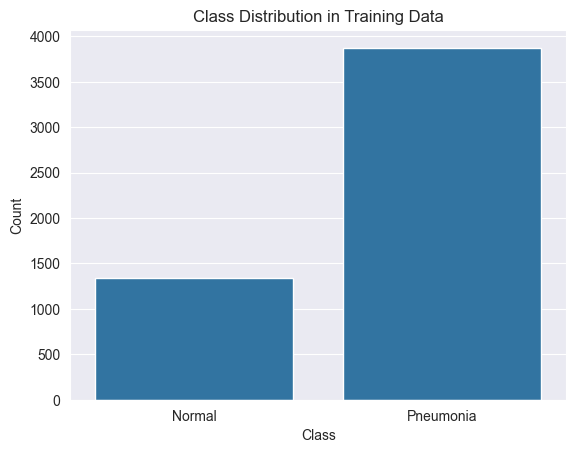

In [27]:
label_map = {1: "Pneumonia", 0: "Normal"}
l = [label_map[label] for label in train_labels]

sns.set_style('darkgrid')
sns.countplot(x=l)
plt.title("Class Distribution in Training Data")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

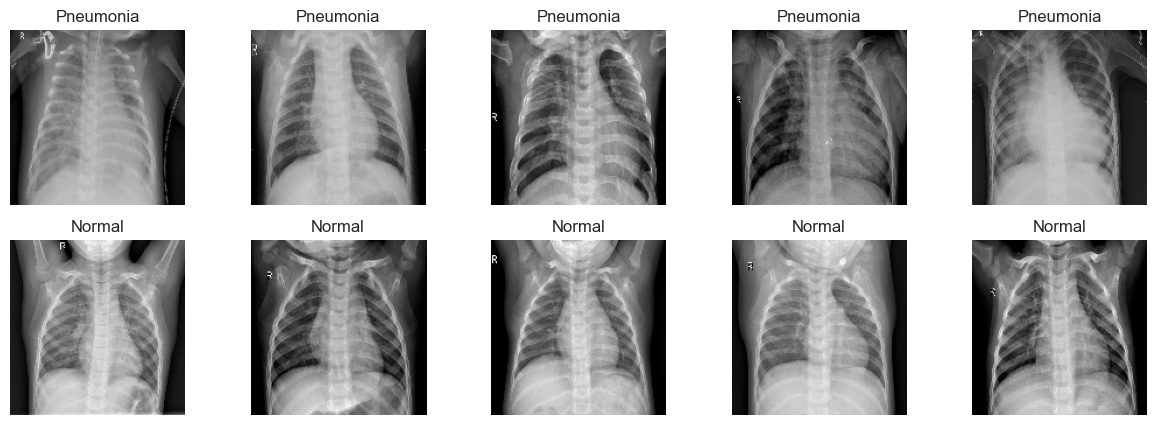

In [35]:
# Separate images based on their labels
normal_images = [train_data[i] for i in range(len(train_labels)) if train_labels[i] == 0]
pneumonia_images = [train_data[i] for i in range(len(train_labels)) if train_labels[i] == 1]

# Plot 3 Pneumonia images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(2, 5, i+1)  # 2 rows, 3 columns, i+1th subplot
    plt.imshow(pneumonia_images[i].reshape(img_size, img_size), cmap='gray')
    plt.title("Pneumonia")
    plt.axis('off')  # Hide axes

# Plot 3 Normal images
for i in range(5):
    plt.subplot(2, 5, i+6)  # 2 rows, 3 columns, i+4th subplot
    plt.imshow(normal_images[i].reshape(img_size, img_size), cmap='gray')
    plt.title("Normal")
    plt.axis('off')  # Hide axes

plt.show()

We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].

In [36]:
# Normalize the data
x_train = np.array(train_data) / 255
x_val = np.array(val_data) / 255
x_test = np.array(test_data) / 255

In [37]:
x_test

array([[[0.14117647, 0.1254902 , 0.1254902 , ..., 0.1254902 ,
         0.1372549 , 0.12941176],
        [0.11764706, 0.11764706, 0.11764706, ..., 0.11764706,
         0.11372549, 0.12156863],
        [0.13333333, 0.1254902 , 0.1254902 , ..., 0.1254902 ,
         0.1254902 , 0.1254902 ],
        ...,
        [0.12156863, 0.10588235, 0.11372549, ..., 0.11764706,
         0.12941176, 0.1372549 ],
        [0.11764706, 0.11372549, 0.10196078, ..., 0.13333333,
         0.13333333, 0.1254902 ],
        [0.11372549, 0.10980392, 0.11372549, ..., 0.12156863,
         0.11372549, 0.14117647]],

       [[0.1372549 , 0.1254902 , 0.10196078, ..., 0.48627451,
         0.45098039, 0.41960784],
        [0.15686275, 0.12156863, 0.10588235, ..., 0.47058824,
         0.45882353, 0.40784314],
        [0.15294118, 0.13333333, 0.10588235, ..., 0.47843137,
         0.4627451 , 0.40784314],
        ...,
        [0.16862745, 0.14901961, 0.17254902, ..., 0.11764706,
         0.14117647, 0.11764706],
        [0.1

Summary of Why This is Necessary:
Reshaping Image Data: The deep learning model needs the image data in the format (num_samples, height, width, channels) to work with convolution layers effectively. Grayscale images need to have a channel dimension (which is 1), so they are reshaped accordingly.

Converting Labels to NumPy Arrays: Deep learning frameworks need labels in a numerical format (as NumPy arrays or tensors), and they must be able to index and manipulate the labels efficiently during training and evaluation.

What Happens After Reshaping:
After this block of code, your data will be in the proper format:

x_train, x_val, x_test: 4D arrays of shape (num_samples, img_size, img_size, 1), suitable for feeding into a neural network.

y_train, y_val, y_test: 1D arrays containing the labels, which are also ready to be used for training or evaluation.

In [38]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(train_labels)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(val_labels)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(test_labels)

In [39]:
x_train.shape # 5216 images, each 150x150 pixels, with 1 channel for grayscale

(5216, 150, 150, 1)

In [40]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

This model is a Convolutional Neural Network (CNN) designed for binary classification tasks, typically used in image classification. It consists of several layers aimed at extracting features from input images:

1. **Convolutional Layers**: The model uses multiple convolutional layers with increasing numbers of filters (32, 64, 128, 256), each applying 3x3 kernels to extract spatial features. These layers help in identifying patterns such as edges, textures, and more complex shapes in the images.

2. **Max-Pooling Layers**: After each convolutional block, max-pooling is applied to reduce the spatial dimensions of the feature maps, which helps in reducing computational load and controlling overfitting. The pooling size is 2x2 with a stride of 2.

3. **Batch Normalization**: This layer is used after each convolutional block to normalize the activations, which helps speed up training and stabilizes the learning process.

4. **Dropout Layers**: Dropout is used in several layers (0.1 or 0.2) to prevent overfitting. It randomly deactivates a fraction of neurons during training, forcing the model to generalize better.

5. **Flattening**: After feature extraction, the 2D feature maps are flattened into a 1D vector to be fed into fully connected (dense) layers.

6. **Dense Layers**: The model has one fully connected layer with 128 units and a ReLU activation function, followed by another dropout layer to improve generalization. The output layer is a single neuron with a sigmoid activation function, providing a probability value between 0 and 1 for binary classification.

7. **Model Compilation**: The model uses the RMSprop optimizer and binary crossentropy loss function, which are appropriate for binary classification problems. The metric used for evaluation is accuracy.

Overall, this CNN model is structured to extract hierarchical features from input images and classify them into two categories with high accuracy, using techniques like batch normalization, dropout, and max-pooling to improve training efficiency and prevent overfitting.

In [51]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

C:\Users\salom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [53]:
model_ran = model
model_ran.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [43]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [44]:
bool_train_cnn = True
if bool_train_cnn:
    trained_model_cnn = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])
    # Save the entire model (architecture + weights + optimizer state)
    model.save('part2_cnn_model.h5')

Epoch 1/12


C:\Users\salom\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 459ms/step - accuracy: 0.7980 - loss: 1.2223 - val_accuracy: 0.5000 - val_loss: 26.1328 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 398ms/step - accuracy: 0.8914 - loss: 0.2824 - val_accuracy: 0.5000 - val_loss: 72.7277 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9111 - loss: 0.2451
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 393ms/step - accuracy: 0.9111 - loss: 0.2450 - val_accuracy: 0.5000 - val_loss: 30.3711 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 395ms/step - accuracy: 0.9416 - loss: 0.1578 - val_accuracy: 0.5000 - val_loss: 33.2442 - learning_rate: 3.0000e-04
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.9524 - loss: 0.1420
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 382ms/step - accuracy: 0.9525 - l

In [64]:
model = load_model('part2_cnn_model.h5')

In [66]:
y_pred = (model.predict(x_test) > 0.5).astype("int32")  # Thresholding for binary classification
# Create a histogram of model_ran.predict(x_test)
predictions = model.predict(x_test)
# Split predictions by label
predictions_normal = predictions[y_test == 0]
predictions_pneumonia = predictions[y_test == 1]

loss, accuracy = model.evaluate(x_test, y_test)
f1 = f1_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("F1 score of the model is - " , f1)
print("Balanced Accuracy of the model is - " , balanced_accuracy, "%")



20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9077 - loss: 0.2911
F1 score of the model is -  0.9278350515463918
Balanced Accuracy of the model is -  0.905982905982906 %


In [68]:
def plot_predictions(predictions, y_test):
    """
    Plots a histogram of prediction distributions and a scatter plot of predictions vs. true labels.

    Parameters:
    - predictions: array-like, all model predictions (used for scatter plot)
    - y_test: array-like, true labels corresponding to predictions
    """

    predictions_normal = predictions[y_test == 0]
    predictions_pneumonia = predictions[y_test == 1]

    # Histogram
    plt.hist(predictions_normal, bins=20, color='blue', alpha=0.7, label='Normal')
    plt.hist(predictions_pneumonia, bins=20, color='orange', alpha=0.7, label='Pneumonia')
    plt.title("Histogram of Predictions by Label")
    plt.xlabel("Prediction Values")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

    # Scatter plot
    plt.scatter(predictions, y_test, alpha=0.5, color='red')
    plt.title("Scatter Plot of Predictions vs True Labels")
    plt.xlabel("Prediction Values")
    plt.ylabel("True Labels")
    plt.show()


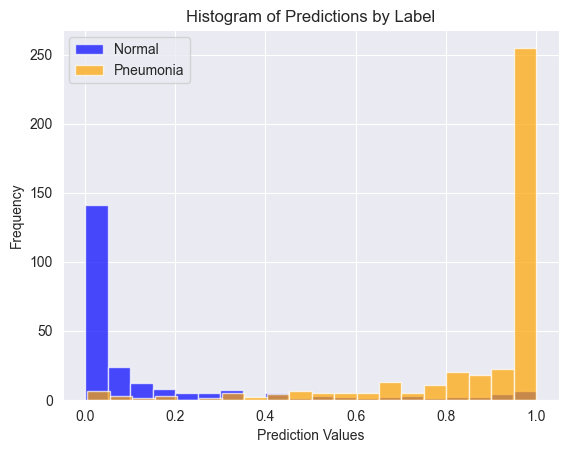

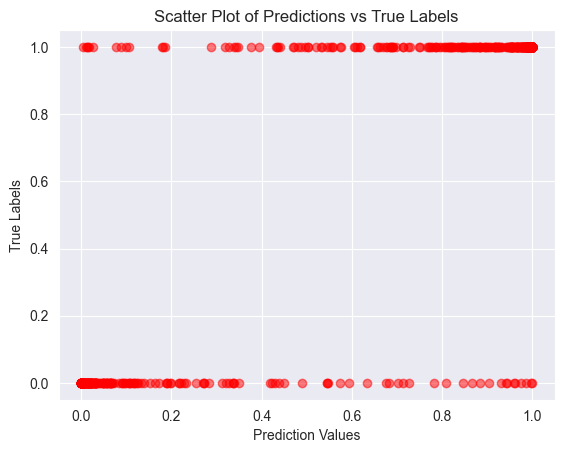

In [69]:
plot_predictions(predictions, y_test)

## Q5: Data Randomization Test

In [54]:
y_train_rand = np.random.permutation(y_train)  # shuffle labels
y_train_rand


array([1, 1, 1, ..., 1, 1, 0])

In [55]:
bool_train_ran = True
if bool_train_ran:
    trained_model_rand = model_ran.fit(datagen.flow(x_train,y_train_rand, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])
    model_ran.save('part2_q5_cnn_model_ran_labels.h5')


Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 455ms/step - accuracy: 0.7056 - loss: 1.4199 - val_accuracy: 0.5000 - val_loss: 1.5912 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 61s 373ms/step - accuracy: 0.7548 - loss: 0.5782 - val_accuracy: 0.6250 - val_loss: 0.7342 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 60s 369ms/step - accuracy: 0.7450 - loss: 0.5892 - val_accuracy: 0.4375 - val_loss: 1.3817 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.7459 - loss: 0.5885
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 61s 372ms/step - accuracy: 0.7459 - loss: 0.5885 - val_accuracy: 0.4375 - val_loss: 0.7427 - learning_rate: 0.0010
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 61s 373ms/step - accuracy: 0.7451 - loss: 0.5783 - val_accuracy: 0.5000 - val_loss: 0.7273 - learning_rate: 3.0000e-04
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.

In [48]:
model_ran = load_model('part2_cnn_model_ran_lables.h5')

In [70]:
y_pred_ran = (model_ran.predict(x_test) > 0.5).astype("int32")  # Thresholding for binary classification
# Create a histogram of model_ran.predict(x_test)
predictions_ran = model_ran.predict(x_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


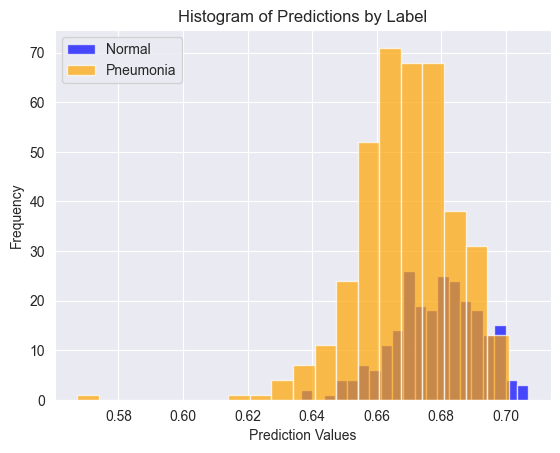

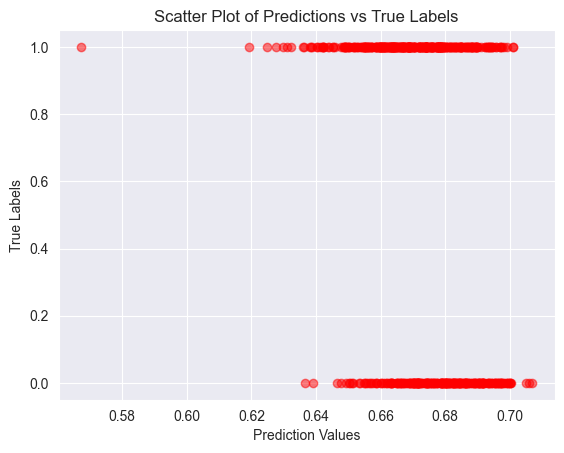

In [71]:
plot_predictions(predictions = predictions_ran, y_test= y_test)

In [72]:

loss, accuracy = model_ran.evaluate(x_test, y_test)
f1_ran = f1_score(y_test, y_pred_ran)
balanced_accuracy_ran = balanced_accuracy_score(y_test, y_pred_ran)
print("F1 score of the model is - " , f1_ran)
print("Accuracy of the model is - " , accuracy)
print("Balanced Accuracy of the model is - " , balanced_accuracy_ran, "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.2984 - loss: 0.9128
F1 score of the model is -  0.7692307692307693
Accuracy of the model is -  0.625
Balanced Accuracy of the model is -  0.5 %


# Implementing Saliency Methods

##  Integrated Gradients (IG)

In [116]:
def integrated_gradients(model, img, target_class_idx, baseline=None, steps=50):
    if baseline is None:
        baseline = np.zeros_like(img)
    # Scale image and baseline to float
    img = img.astype(np.float32)
    baseline = baseline.astype(np.float32)
    # 1. Generate interpolation path
    interpolated_imgs = [(baseline + (i/steps)*(img - baseline)) for i in range(steps+1)]
    interpolated_imgs = np.array(interpolated_imgs, dtype=np.float32)
    # 2. Compute gradients at each step
    grads = []
    for interp_img in interpolated_imgs:
        interp_img_tensor = tf.convert_to_tensor(interp_img[None, ...])  # shape: (1, H, W, C)
        with tf.GradientTape() as tape:
            tape.watch(interp_img_tensor)
            pred = model(interp_img_tensor)
            class_score = pred[0, 0]
        grad = tape.gradient(class_score, interp_img_tensor)[0]  # remove batch dim
        grads.append(grad.numpy())
    grads = np.array(grads, dtype=np.float32)
    # 3. Average gradients (trapezoidal rule)
    avg_grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grad = np.mean(avg_grads, axis=0)
    # 4. Integrated gradients
    integrated_grad = (img - baseline) * avg_grad
    return integrated_grad  # same shape as input image


In [74]:
# Normalize for display
def normalize(arr):
    arr = np.abs(arr)
    arr = arr / (np.max(arr) + 1e-8)
    return arr

In [110]:
img = x_test[0]
label = y_test[0]
baseline = np.zeros_like(img) # create a black baseline of same shape
preds_rand = model.predict(np.expand_dims(img, axis=0))
preds_rand = model.predict(np.expand_dims(img, axis=0))
print(preds_rand)
target_class_rand = int(preds_rand> 0.5)
print(target_class_rand)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[0.0008326]]
0


C:\Users\salom\AppData\Local\Temp\ipykernel_29324\3098252800.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  target_class_rand = int(preds_rand> 0.5)


In [111]:
print(img)
label

[[[0.14117647]
  [0.1254902 ]
  [0.1254902 ]
  ...
  [0.1254902 ]
  [0.1372549 ]
  [0.12941176]]

 [[0.11764706]
  [0.11764706]
  [0.11764706]
  ...
  [0.11764706]
  [0.11372549]
  [0.12156863]]

 [[0.13333333]
  [0.1254902 ]
  [0.1254902 ]
  ...
  [0.1254902 ]
  [0.1254902 ]
  [0.1254902 ]]

 ...

 [[0.12156863]
  [0.10588235]
  [0.11372549]
  ...
  [0.11764706]
  [0.12941176]
  [0.1372549 ]]

 [[0.11764706]
  [0.11372549]
  [0.10196078]
  ...
  [0.13333333]
  [0.13333333]
  [0.1254902 ]]

 [[0.11372549]
  [0.10980392]
  [0.11372549]
  ...
  [0.12156863]
  [0.11372549]
  [0.14117647]]]


np.int64(0)

In [115]:
def compare_ig_maps(model1, model2, imgs, labels=None, class_names=None, num_images=5, return_maps=True):
    """
    Compare IG maps for model1 and model2 on multiple input images.
    Optionally return the IG maps for further analysis.

    Returns (if return_maps=True):
        ig_maps_model1: list of IG maps from model1
        ig_maps_model2: list of IG maps from model2
    """
    ig_maps_model1 = []
    ig_maps_model2 = []

    for i in range(num_images):
        img = imgs[i]
        
        # Predict class for model1
        preds1 = model1.predict(img[None, ...])
        class_idx1 = int(preds1 > 0.5)

        print(f"Model 1 Prediction: {preds1}, Class Index: {class_idx1}")
        
        # Predict class for model2
        preds2 = model2.predict(img[None, ...])
        class_idx2 = int(preds2 > 0.5)

        print(f"Model 1 Prediction: {preds2}, Class Index: {class_idx2}")

        # Compute IG maps
        ig_map1 = integrated_gradients(model1, img, class_idx1)
        ig_map2 = integrated_gradients(model2, img, class_idx2)

        ig_maps_model1.append(ig_map1)
        ig_maps_model2.append(ig_map2)

        # Plot
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(img.squeeze(), cmap='gray')
        title = f"Image #{i}"
        if class_names and labels is not None:
            true_class = class_names[labels[i]]
            title += f" (True: {true_class})"
        plt.title(title)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.imshow(normalize(ig_map1), cmap='jet', alpha=0.5)
        name1 = class_names[class_idx1] if class_names else f"Class {class_idx1}"
        plt.title(f"IG: Original Model\nPred: {name1}")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.imshow(normalize(ig_map2), cmap='jet', alpha=0.5)
        name2 = class_names[class_idx2] if class_names else f"Class {class_idx2}"
        plt.title(f"IG: Random Model\nPred: {name2}")
        plt.axis('off')

        plt.tight_layout()
        plt.show()
    
    if return_maps:
        return ig_maps_model1, ig_maps_model2


In [98]:
print(y_test.size)
print(y_test[0:5])
print(y_test[620:624])

624
[0 0 0 0 0]
[1 1 1 1]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Model 1 Prediction: [[0.0008326]], Class Index: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Model 1 Prediction: [[0.6747803]], Class Index: 1


C:\Users\salom\AppData\Local\Temp\ipykernel_29324\1357244862.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_idx1 = int(preds1 > 0.5)
C:\Users\salom\AppData\Local\Temp\ipykernel_29324\1357244862.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_idx2 = int(preds2 > 0.5)


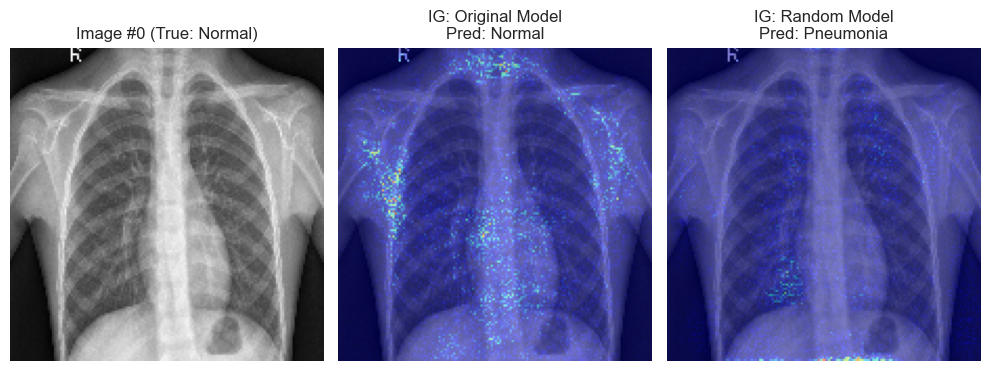

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Model 1 Prediction: [[6.6719e-05]], Class Index: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Model 1 Prediction: [[0.67040277]], Class Index: 1


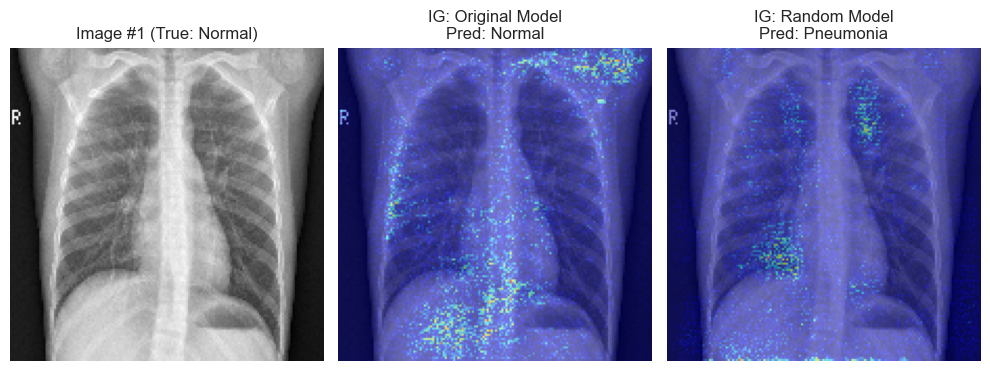

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Model 1 Prediction: [[0.0059923]], Class Index: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Model 1 Prediction: [[0.6672156]], Class Index: 1


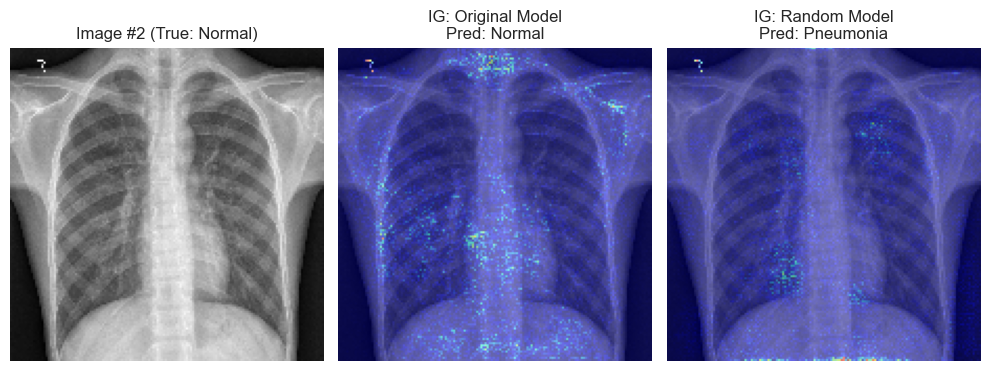

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Model 1 Prediction: [[0.00054625]], Class Index: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Model 1 Prediction: [[0.68046343]], Class Index: 1


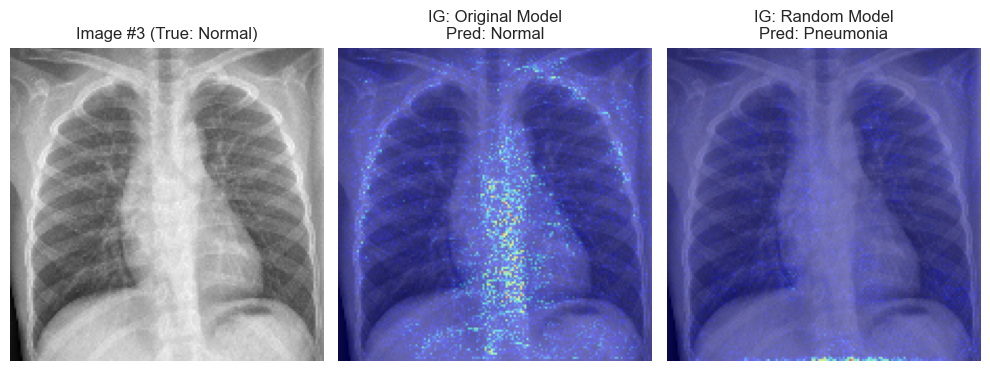

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Model 1 Prediction: [[0.00299255]], Class Index: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Model 1 Prediction: [[0.66301703]], Class Index: 1


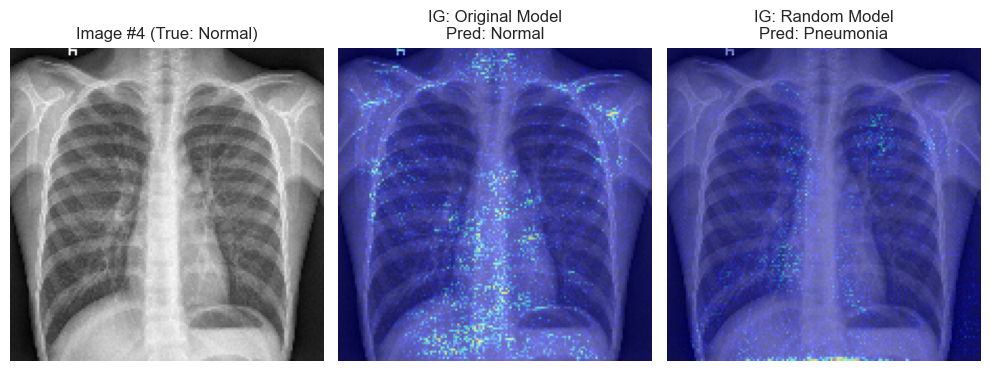

In [117]:
class_names = ["Normal", "Pneumonia"]
x_test_subset = x_test[0:5]  # Select first 5 images for comparison
label_subset = y_test[0:5]  # Corresponding labels for the selected images
ig_maps = compare_ig_maps(model, model_ran, x_test_subset, labels=label_subset, class_names=class_names, num_images=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Model 1 Prediction: [[0.99999946]], Class Index: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Model 1 Prediction: [[0.6732365]], Class Index: 1


C:\Users\salom\AppData\Local\Temp\ipykernel_29324\1357244862.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_idx1 = int(preds1 > 0.5)
C:\Users\salom\AppData\Local\Temp\ipykernel_29324\1357244862.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  class_idx2 = int(preds2 > 0.5)


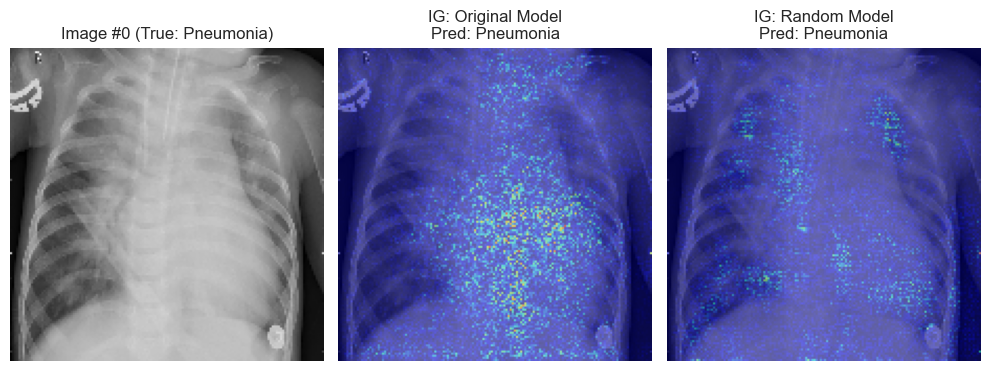

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Model 1 Prediction: [[0.9998182]], Class Index: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Model 1 Prediction: [[0.6595958]], Class Index: 1


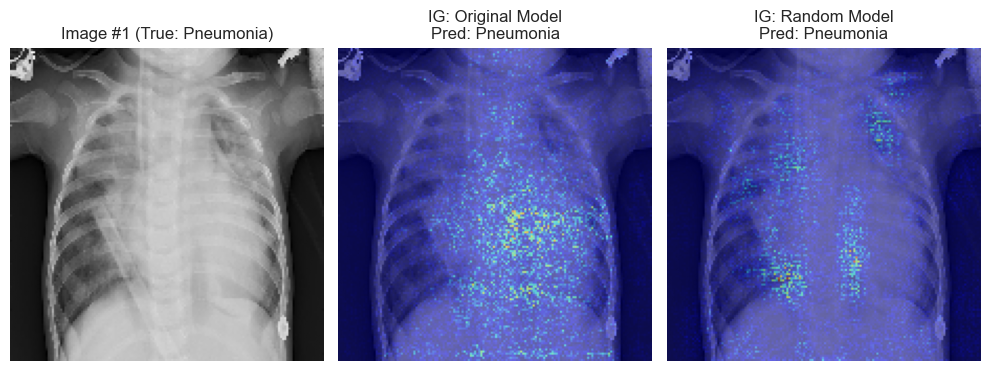

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Model 1 Prediction: [[0.9984527]], Class Index: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Model 1 Prediction: [[0.66892517]], Class Index: 1


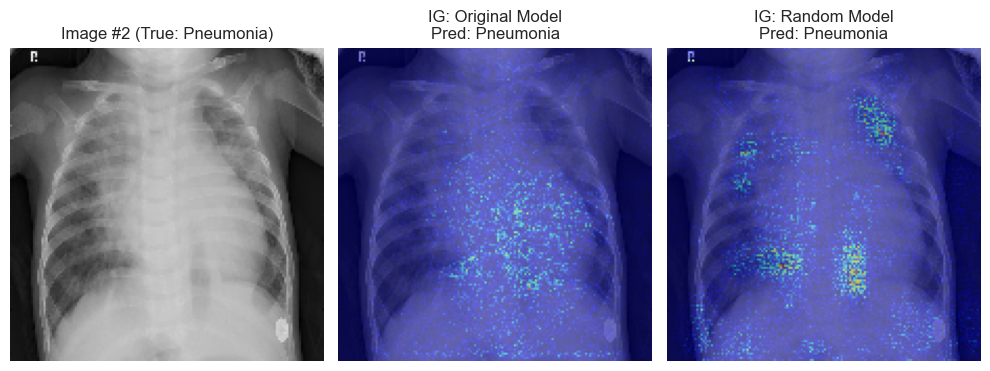

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Model 1 Prediction: [[0.9902638]], Class Index: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Model 1 Prediction: [[0.64891875]], Class Index: 1


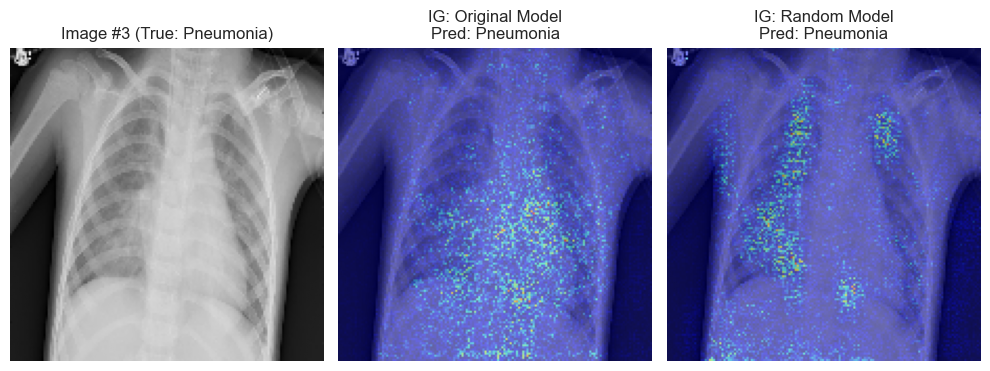

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Model 1 Prediction: [[0.83663803]], Class Index: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Model 1 Prediction: [[0.6795142]], Class Index: 1


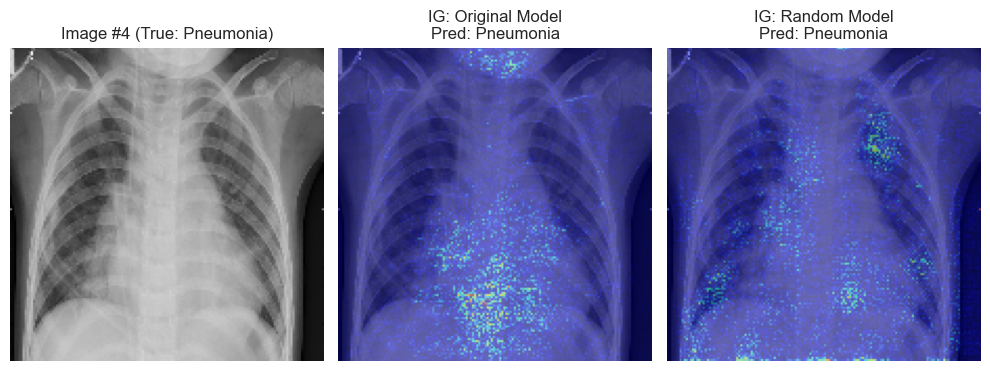

In [118]:
x_test_subset = x_test[618:623]  # Select first 5 images for comparison
label_subset = y_test[618:623]  # Corresponding labels for the selected images
ig_maps = compare_ig_maps(model, model_ran, x_test_subset, labels=label_subset, class_names=class_names, num_images=5)

In [94]:
print(label_subset)
print(y_pred[618:623])
print(y_pred_ran[618:623])

[1 1 1 1 1]
[[1]
 [1]
 [1]
 [1]
 [1]]
[[1]
 [1]
 [1]
 [1]
 [1]]


In [111]:
ig_maps

([array([[[ 2.0757357e-06],
          [-6.6971556e-06],
          [-1.7896309e-05],
          ...,
          [ 1.6499494e-04],
          [-7.7070319e-05],
          [ 2.7800034e-04]],
  
         [[ 1.9148047e-06],
          [ 1.3161228e-05],
          [ 6.8395348e-05],
          ...,
          [-1.6116493e-04],
          [ 5.3106941e-04],
          [-4.3689375e-04]],
  
         [[-2.1293336e-05],
          [ 2.6406216e-05],
          [ 1.5197153e-05],
          ...,
          [ 1.4182603e-03],
          [-4.5781705e-04],
          [ 3.4008946e-04]],
  
         ...,
  
         [[-0.0000000e+00],
          [-0.0000000e+00],
          [-0.0000000e+00],
          ...,
          [-0.0000000e+00],
          [-0.0000000e+00],
          [-0.0000000e+00]],
  
         [[-0.0000000e+00],
          [-0.0000000e+00],
          [-0.0000000e+00],
          ...,
          [ 0.0000000e+00],
          [ 0.0000000e+00],
          [-0.0000000e+00]],
  
         [[ 0.0000000e+00],
          [ 0.000000

In [112]:
def evaluate_saliency_similarity(model1, model2, imgs, num_samples=None, steps=50, verbose=False):
    """
    Compare Integrated Gradients saliency maps between two models using SSIM and Spearman correlation.

    Args:
        model1: Original model (trained on true labels)
        model2: Random-label model
        imgs: Numpy array of images (e.g., test set)
        num_samples: Number of images to use (default: all)
        steps: Number of interpolation steps for IG
        verbose: If True, prints individual scores

    Returns:
        ssim_scores: List of SSIM scores
        spearman_scores: List of Spearman rank correlations
    """
    if num_samples is None:
        num_samples = len(imgs)

    ssim_scores = []
    spearman_scores = []

    for i in range(num_samples):
        img = imgs[i]

        # Predict class for both models
        class1 = np.argmax(model1.predict(img[None, ...]))
        class2 = np.argmax(model2.predict(img[None, ...]))

        # Compute IG saliency maps
        ig1 = integrated_gradients(model1, img, class1, steps=steps)
        ig2 = integrated_gradients(model2, img, class2, steps=steps)

        # Normalize and flatten
        ig1_flat = normalize(ig1).flatten()
        ig2_flat = normalize(ig2).flatten()

        # SSIM
        score_ssim = ssim(ig1.squeeze(), ig2.squeeze(), data_range=1.0)
        ssim_scores.append(score_ssim)

        # Spearman correlation
        score_spearman = spearmanr(ig1_flat, ig2_flat).correlation
        spearman_scores.append(score_spearman)

        if verbose:
            print(f"Image {i}: SSIM={score_ssim:.3f}, Spearman={score_spearman:.3f}")

    # Summary
    print(f"\n--- Saliency Similarity Summary ---")
    print(f"Average SSIM: {np.mean(ssim_scores):.3f}")
    print(f"Average Spearman Correlation: {np.mean(spearman_scores):.3f}")

    return ssim_scores, spearman_scores


In [113]:
ssim_scores, spearman_scores = evaluate_saliency_similarity(model, model_ran, x_test_subset, verbose=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image 0: SSIM=0.998, Spearman=0.347
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Image 1: SSIM=1.000, Spearman=0.310
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Image 2: SSIM=1.000, Spearman=0.206
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Image 3: SSIM=1.000, Spearman=0.131
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Image 4: SSIM=1.000, Spearman=0.188

--- Saliency Similarity Summary ---
Average SSIM: 0.999
Average Spearman Correlation: 0.237
